**Name: Mohamed Magdy Abdelsatar Elsaid Atta**

**Study Track: MIR Master**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Deep Learning Lab : Building a U-Net for Image Segmentation
Objective

The goal of this lab is to design and implement a U-Net neural network for image segmentation. The network will process infrared images captured by a camera mounted on an autonomous drone boat. The purpose of the segmentation task is to distinguish the sea from the sky. This segmentation will serve two primary purposes:  

*   Filtering out detections located in the sky.
*    Calculating the distance of a detection relative to the camera based on its distance from the horizon.
   

# Problem Context

Autonomous drone boats rely on visual data to make navigation and detection decisions. Infrared cameras are particularly useful in low-light or challenging environments, such as at night or during foggy conditions. However, to ensure accurate analysis, it is essential to segment the images to separate the sea from the sky.

In this lab, I will build and train a U-Net, a convolutional neural network architecture specifically designed for image segmentation tasks. The U-Net will label each pixel in the image as either "sea" or "sky." The resulting segmentation map will be used for filtering out false detections in the sky and estimating distances based on the location of the horizon.


In [4]:
import os
from zipfile import ZipFile
# List of ZIP files
zip_files = ['/content/drive/MyDrive/MIR/train_frames-20250112T192858Z-001.zip',
                  '/content/drive/MyDrive/MIR/train_masks-20250112T192152Z-001.zip',
                  '/content/drive/MyDrive/MIR/val_frames-20250112T193230Z-001.zip',
                  '/content/drive/MyDrive/MIR/val_masks-20250112T193113Z-001.zip',
                  '/content/drive/MyDrive/MIR/test_frames-20250112T193440Z-001.zip',
                  '/content/drive/MyDrive/MIR/test_masks-20250112T193603Z-001.zip']
# Destination folder for unzippedfiles
base_destination = '/content/MIR/datasets'
# Create the base destination folder if it doesn't exist
os.makedirs(base_destination, exist_ok=True)
# Loop through the ZIP files and extract each
for zip_file in zip_files:
  destination = os.path.join(base_destination, os.path.splitext(zip_file)[0])
  # Folder named after the ZIP file
  os.makedirs(destination, exist_ok=True)
  # Ensure the folder exists
  with ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(destination)
    # Extract to the specific folder
    print(f"Extracted {zip_file} to {destination}")
# List all folders created
print("Unzipped folders:")
print(os.listdir(base_destination))

Extracted /content/drive/MyDrive/MIR/train_frames-20250112T192858Z-001.zip to /content/drive/MyDrive/MIR/train_frames-20250112T192858Z-001
Extracted /content/drive/MyDrive/MIR/train_masks-20250112T192152Z-001.zip to /content/drive/MyDrive/MIR/train_masks-20250112T192152Z-001
Extracted /content/drive/MyDrive/MIR/val_frames-20250112T193230Z-001.zip to /content/drive/MyDrive/MIR/val_frames-20250112T193230Z-001
Extracted /content/drive/MyDrive/MIR/val_masks-20250112T193113Z-001.zip to /content/drive/MyDrive/MIR/val_masks-20250112T193113Z-001
Extracted /content/drive/MyDrive/MIR/test_frames-20250112T193440Z-001.zip to /content/drive/MyDrive/MIR/test_frames-20250112T193440Z-001
Extracted /content/drive/MyDrive/MIR/test_masks-20250112T193603Z-001.zip to /content/drive/MyDrive/MIR/test_masks-20250112T193603Z-001
Unzipped folders:
[]


In [21]:
import os
project_path = "/content/drive/MyDrive/MIR"
data_set_path = "/content/drive/MyDrive/MIR"
TRAIN_IMG_DIR = os.path.join(data_set_path,"train_frames-20250112T192858Z-001/train_frames/train")
TRAIN_MASK_DIR = os.path.join(data_set_path,"train_masks-20250112T192152Z-001/train_masks/train")
VAL_IMG_DIR = os.path.join(data_set_path,"val_frames-20250112T193230Z-001/val_frames/val")
VAL_MASK_DIR = os.path.join(data_set_path,"val_masks-20250112T193113Z-001/val_masks/val")
CHECKPOINT_PATH = os.path.join(project_path,"Save/my_checkpoint.pth.tar")
PLOT_PATH = os.path.join(project_path,"Save/Accuracy")
PLOT_VAL_PATH = os.path.join(project_path,"Save/validation")

# Dataset
https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [6]:
import os
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import pdb

## Dataset Class
Questions:
1. Explain what the get_item function is for and how it is called in training mechanism?
2. why do we have to divide mask by 255?


In [ ]:
class HorizonDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

# a HorizonDataset class that derives from the pytorch Dataset class and complete the __getitem__(self, index) method.
    def __getitem__(self, index):
      #The goal of the function is:
      #1.loading the data
      #2.perform the data transformations
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index])
        #...#
        #open image and mask then convert them to numpy arrays
        image = np.array(Image.open(img_path).convert('RGB'),dtype=np.float32)
        mask = np.array(Image.open(mask_path).convert('L'),dtype=np.float32)
        #...#
        #we have to divide mask by 255 to normalize the values to be [0,1]
        mask = mask/255.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return (image, mask)

## Loader definition
Questions:
1. Explain what the data loader is for?

In [8]:
#answer: dataloader is used mainly to divide the dataset into batches and adjust the shuffling parameters

# The data loader allows you to iterate over the dataset.
# Each iteration below returns a batch of train_features and train_labels

def get_loaders(
    train_dir,
    train_maskdir,
    val_dir,
    val_maskdir,
    batch_size,
    train_transform,
    val_transform,
    num_workers=4,
    pin_memory=True,
):
    train_ds = HorizonDataset(
        image_dir=train_dir,
        mask_dir=train_maskdir,
        transform=train_transform,
    )

# Warning to shuffle (true or false ??? explain why in commentary)
# answer: shuffle in training dataset should be set to True,
#because this improves the optimizer efficiency and allow for better generalization
    train_loader =  DataLoader(train_ds, shuffle=True,
                               batch_size=batch_size,
                               pin_memory = pin_memory ,num_workers=num_workers)

    val_ds = HorizonDataset(
        image_dir=val_dir,
        mask_dir=val_maskdir,
        transform=val_transform,
    )
# Warning to shuffle (true or false ??? explain why in commentary)
#answer: shuffle in validation and testing dataset should be set to False,
#because this introduce consistency to the evaluation process
    val_loader = DataLoader(val_ds, shuffle=False,
	  batch_size=batch_size, pin_memory=pin_memory,
	  num_workers=num_workers)

    return train_loader, val_loader

# Model definition
https://www.pinecone.io/learn/batch-layer-normalization/

https://medium.com/data-science-365/batch-normalization-explained-in-plain-english-3436014f9e52

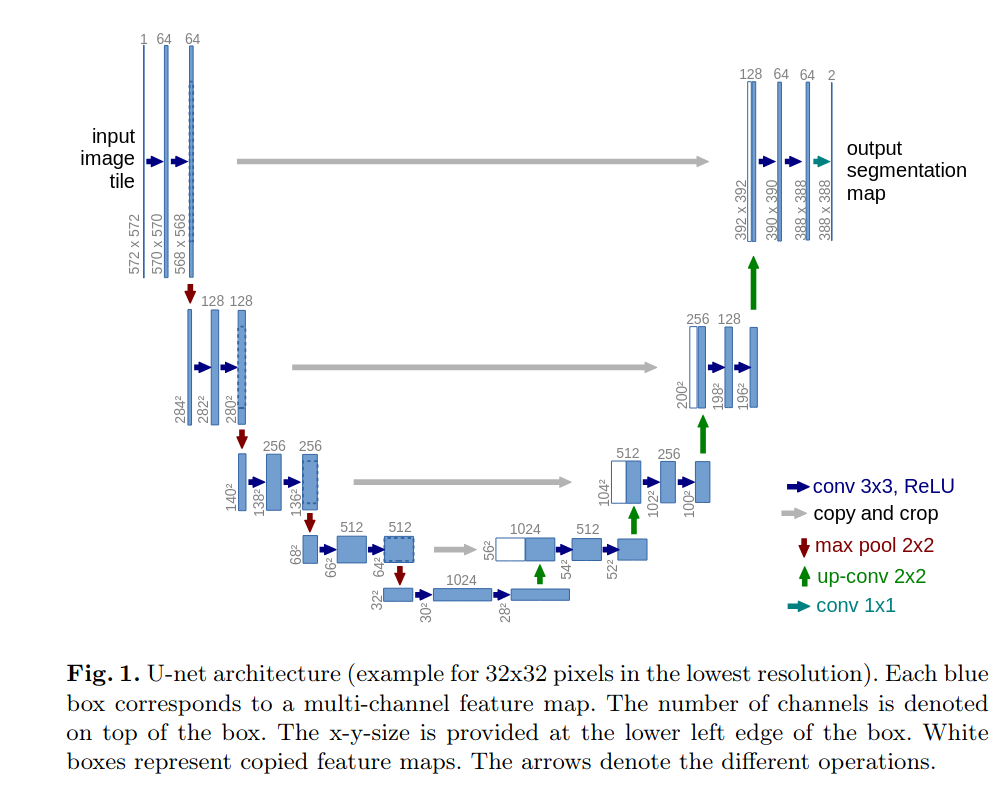

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF


# this code will first check if there is a gpu to run the code using it
#, otherwise it will run the code in hte cpu
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

## Double convolution
Questions:
1. From the network diagram above, code an elementary brick composed of a convolution layer.Do the same but limiting to a single convolution layer.

In [10]:
 #Conv2d -> BatchNorm2d -> ReLU -> Conv2d -> BatchNorm2d ->  ReLU#
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            #defining the double convolution block that is used in each
            #layer of the down and up parts of the network
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
          )

    def forward(self, x):
        return self.conv(x)

In [11]:
# The same but with only one sequence
class SimpleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
        super(SimpleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
            )

  def forward(self, x):
        return self.conv(x)


## Model
https://arxiv.org/pdf/1505.04597.pdf

Questions :
1.  Complete the model code from the publication schema.
2.  Complete the descending part then the rising part of the Unet.
3.  For the rising part, use ConvTranspose2d
4.  Use the DoubleConv function first and then the SimpleConv, make comments

In [12]:
class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET

        #...#
        #defining the four steps in the down part of the network based on the give features values
        self.downs.append(DoubleConv(in_channels, features[0]))
        self.downs.append(DoubleConv(features[0], features[1]))
        self.downs.append(DoubleConv(features[1], features[2]))
        self.downs.append(DoubleConv(features[2], features[3]))

        #defining the double convolution step in the bottleneck part of the network based on the give features values
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)

        # Up part of UNET
        #...#
        #defining the four steps in the up part of the network based on the give features values
        self.ups.append(nn.ConvTranspose2d(features[3]*2,features[3],kernel_size=2,stride=2))
        self.ups.append(DoubleConv(features[3]*2,features[3]))
        self.ups.append(nn.ConvTranspose2d(features[2]*2,features[2],kernel_size=2,stride=2))
        self.ups.append(DoubleConv(features[2]*2,features[2]))
        self.ups.append(nn.ConvTranspose2d(features[1]*2,features[1],kernel_size=2,stride=2))
        self.ups.append(DoubleConv(features[1]*2,features[1]))
        self.ups.append(nn.ConvTranspose2d(features[0]*2,features[0],kernel_size=2,stride=2))
        self.ups.append(DoubleConv(features[0]*2,features[0]))

        #defining the final convolution to get the output segmentation map
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

# Evaluation metric
Evaluation metrics are quantitative measures used to assess the performance and effectiveness of a statistical or machine learning model. These metrics provide insights into how well the model is performing and help in comparing different models or algorithms.

https://www.analyticsvidhya.com/blog/2019/08/11-important-model-evaluation-error-metrics/

Q: Write a function which calculates the accuracy which is the number of pixels OK compared to the total number of pixels and which calculates the dice score. This function will return the dice score as a validation metric.
Comment on the use of model.eval() and model.train()

In [13]:
def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval() #first we set mode to eval to ensure evaluation is done in a deterministic way
    #without any dropouts or unstable batch normalizations

    with torch.no_grad():
        for x, y_true in loader:
          x ,y_true = x.to(device), y_true.to(device)
          predictions = model(x) #make prediction
          #...#
          y_pred = torch.sigmoid(predictions) #getting probabilities
          y_pred = (y_pred > 0.5).float() #applying thresholding
          if y_pred.dim() == 4:  # Check if channel dimension exists (B, C, H, W)
                y_pred = y_pred.squeeze(1)

          intersection = (y_pred * y_true).sum()
          sum_pred = y_pred.sum()
          sum_true = y_true.sum()
          dice = (2.0 * intersection) / (sum_pred + sum_true + 1e-8)
          dice_score += dice.item() #getting the dice score
          num_correct += (y_pred == y_true).sum().item()    # Get the pixels correctly classified
          num_pixels += torch.numel(y_true)        # Get the total number of pixels

    val_accuracy = dice_score/len(loader) #getting the validation accuracy

    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    )
    print(f"Dice score: {val_accuracy}")
    model.train() # we set the mode to training to restore the training configuration and
    #allow the use of dropouts and avoiding the use of frozen batch normalizations to get our
    #desired performance during training

    return val_accuracy


# Training
https://www.analyticsvidhya.com/blog/2023/01/gradient-descent-vs-backpropagation-whats-the-difference/

In [14]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_WORKERS = 2
IMAGE_HEIGHT = 128  # 1280 originally
IMAGE_WIDTH = 256  # 1918 originally
PIN_MEMORY = True
LOAD_MODEL = False


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.2 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Hyper parameters

In [15]:
class HyperParameters:
    def __init__(self, learning_rate, batch_size,epoch_numbers,device):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epoch_numbers = epoch_numbers
        self.device = device

## Train function
Qestions
1. Write a function that calculates the loss on validation data.
2. Write a function that saves an image and the network prediction for each epoch to visualize the learning progress.
3. Write a function that calculates the loss on training data.
4. Make a comment on optimizer.zero_grad(), scaler.scale(loss).backward(),scaler.step(optimizer), scaler.update()


In [16]:
def check_val_loss(loader, model,loss_fn, device="cuda"):
    totalValLoss = 0.0
    model.eval()

    with torch.no_grad():
        for data, targets in loader:
          data, targets = data.to(device), targets.float().unsqueeze(1).to(device) #moving inputs and targets to the selected GPU or CPU device
          outputs = model(data)
          loss = loss_fn(outputs, targets) #calculating the loss
          totalValLoss += loss.item() #calculating the loss for all batches


    val_loss = totalValLoss/len(loader) #calculating the average loss for the whole validation dataset
    print(f"Val loss: {val_loss}")
    model.train()

    return val_loss

def save_eval(loader, model,epoch,file_path="eval_image", device="cuda"):

    model.eval()

    with torch.no_grad():
        val_images, val_masks = next(iter(loader))
        val_images = val_images.to(device)
        filename = file_path +"_" +str(epoch)
        predictions = model(val_images) #getting predictions
        preds = torch.sigmoid(predictions) #getting the probabilities
        # save eval
        #...#
        preds = (preds > 0.5).float() #applying thresholding
        input_image = val_images[0].cpu() #getting the first image
        true_mask = val_masks[0].cpu().unsqueeze(0)  # Add channel dimension and getting the ground truth mask
        pred_mask = preds[0, 0, :, :].cpu().numpy() #getting hte predicted mask
        #plotting the input image, the true mask , and the predicted mask.
        f = plt.figure(figsize=(15, 3))
        f.add_subplot(1,3, 1)
        plt.imshow(input_image[0], cmap="gray")
        plt.title("Input image")
        f.add_subplot(1,3, 2)
        plt.imshow(true_mask[0], cmap="gray")
        plt.title("True mask")
        f.add_subplot(1,3, 3)
        plt.imshow(pred_mask, cmap="gray")
        plt.title("Predicted mask")
        plt.show(block=True)
        plt.savefig(filename) #saving the figure
        plt.close(f)


    model.train()


In [17]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)
    totalTrainLoss = 0.0

    for batch_idx, (data, targets) in enumerate(loop): #looping over the batches
        #moving data and targets to the selected GPU or CPU
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward pass through the whole U-NET architecture layers
        with torch.cuda.amp.autocast():
            predictions = model(data) #getting predictions
            loss =  loss_fn(predictions,targets) #calculating the batch loss
            totalTrainLoss += loss #accumulating the total loss

        # backward pass to optimize the model
        optimizer.zero_grad() #clearing gradients from previous training step
        scaler.scale(loss).backward() #scaling gradients to remain in a representable range and perform backpropagation
        scaler.step(optimizer) #updating the model parameters and weights using the gradients
        scaler.update() #Dynamically updating the loss scaling factor based on the gradient stability

        # update tqdm loop
        loop.set_postfix(loss=loss.item())
        loop.update()
    loop.close()
    #...#
    train_loss = totalTrainLoss/len(loader)
    print(f"Tain loss: {train_loss}")

    return train_loss


## Training script
Questions:
1. Write a function wich plot and save train_loss, val_loss and val_acc
2. Write a function which save ckeckpoint file
3. Make a comment on:
A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0],
                std=[1.0],
                max_pixel_value=255.0,
            )
4.  Why are transformations missing for validation data?
5.  Why  nn.BCEWithLogitsLoss() is used instead of classical BCE?
6.  Make a comment on: torch.cuda.amp.GradScaler()
7.  What is Adam? What’s the main difference between Adam and SGD?

In [18]:
import matplotlib.pyplot as plt

class Results:
      def __init__(self,file_path="results"):
        self.result_dict = {
	             "train_loss": [],
	              "val_loss": [],
	              "val_acc": []
                }
        self.path = file_path

      def add_result(self, train_loss, val_loss,val_acc):
        self.result_dict["train_loss"].append(train_loss)
        self.result_dict["val_loss"].append(val_loss)
        self.result_dict["val_acc"].append(val_acc)

      def plotAndSave(self,n_epoch):
        #moving our losses and accuracy values to cpu and convert them to numpy arrays to use them in the plotting code
        train_loss_cpu = [tensor.detach().cpu().numpy() if isinstance(tensor, torch.Tensor) else tensor for tensor in self.result_dict["train_loss"]]
        val_loss_cpu = [tensor.detach().cpu().numpy() if isinstance(tensor, torch.Tensor) else tensor for tensor in self.result_dict["val_loss"]]
        val_acc_cpu = [tensor.detach().cpu().numpy() if isinstance(tensor, torch.Tensor) else tensor for tensor in self.result_dict["val_acc"]]

        filename = self.path +"_" +str(n_epoch)
        #plotting the training loss, the validation loss, and the validation accuracy
        plt.figure(figsize=(15, 4))
        plt.subplot(1, 3, 1)
        plt.plot(train_loss_cpu, label="train_loss")
        plt.title("Train loss")
        plt.subplot(1, 3, 2)
        plt.plot(val_loss_cpu, label="val_loss")
        plt.title("Validation loss")
        plt.subplot(1, 3, 3)
        plt.plot(val_acc_cpu, label="val_acc")
        plt.title("Validation accuracy")
        plt.show(block=True)
        plt.savefig(filename)
        plt.close()

In [22]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint: ")
    print(filename)
    #save
    #...""
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    #load
    #...#
    model.load_state_dict(checkpoint["state_dict"])


def run_training(hyper_parameters):

    results = Results(file_path = PLOT_PATH)
    train_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH), #resizing to have all the images with fixed consistent dimensions
            A.Rotate(limit=35, p=1.0), #image random rotation
            A.HorizontalFlip(p=0.5), #image random horizontal flipping
            A.VerticalFlip(p=0.1), #image random vertical flipping
            A.Normalize( #normalize image pixels to [0,1]
                mean=[0.0],
                std=[1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(), #convert image to tensor
        ],
    )
    #Validation data should reflect real-world inference conditions without randomness such as flips/rotates.
    #Only deterministic transforms such as resizing and normalization are applied to ensure consistent evaluation metrics.
    val_transforms = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=[0.0],
                std=[1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

    model = UNET().to(DEVICE)
    #BCEWithLogitsLoss is used instead of Classical BCE because it
    #combines a sigmoid layer and binary cross-entropy loss into a single operation
    #and reduces memory usage by merging two operations.
    loss_fn = nn.BCEWithLogitsLoss()
    #Adam is chosen as the optimizer
    #Adam adapts the learning rate for each parameter individually, while SGD has a fixed learning
    #Adam automates learning rate adaptation, while SGD requires manual tuning
    #Adam has a momentum term to help escape local minima, while SGD does not
    optimizer = optim.Adam(model.parameters(), lr=hyper_parameters.learning_rate)

    train_loader, val_loader = get_loaders(
        TRAIN_IMG_DIR,
        TRAIN_MASK_DIR,
        VAL_IMG_DIR,
        VAL_MASK_DIR,
        hyper_parameters.batch_size,
        train_transform,
        val_transforms,
        NUM_WORKERS,
        PIN_MEMORY,
    )

    if LOAD_MODEL:
        load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)


    check_accuracy(val_loader, model, device=DEVICE)
    #Enabling mixed-precision training (combining FP16 and FP32) to
    #accelerate training and reduce memory usage.
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(hyper_parameters.epoch_numbers):
        train_loss = train_fn(train_loader, model, optimizer, loss_fn, scaler)

        # save model (check point) after training at each epoch
        #...#
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
        }
        save_checkpoint(checkpoint)
        #save_eval(val_loader, model, epoch, PLOT_VAL_PATH, device=DEVICE)

        val_loss = check_val_loss(val_loader, model,loss_fn)

        # check accuracy
        val_accuracy = check_accuracy(val_loader, model, device=DEVICE)

        results.add_result(train_loss, val_loss,val_accuracy)

        results.plotAndSave(epoch)
        save_eval(val_loader, model,epoch,PLOT_VAL_PATH, device=DEVICE)

    return model

# Run Training

<ipython-input-22-a297b9b469b5>:66: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Got 58905624/117800960 with acc 50.00
Dice score: 0.0


  0%|          | 0/1247 [00:00<?, ?it/s]<ipython-input-17-dd9bcf2da15a>:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 1247/1247 [01:38<00:00, 12.65it/s, loss=0.0259]


Tain loss: 0.07845757156610489
=> Saving checkpoint: 
my_checkpoint.pth.tar
Val loss: 0.02551006215072348
Got 116455209/117800960 with acc 98.86
Dice score: 0.9934785344842013


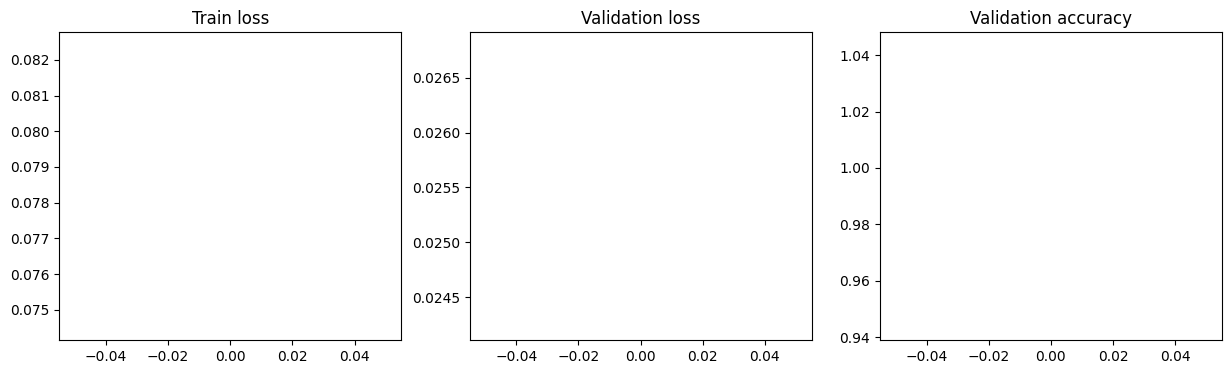

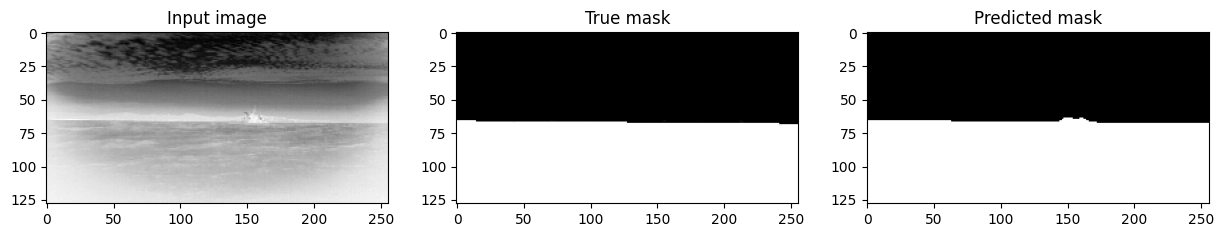

100%|██████████| 1247/1247 [01:37<00:00, 12.80it/s, loss=0.00801]


Tain loss: 0.0274474136531353
=> Saving checkpoint: 
my_checkpoint.pth.tar
Val loss: 0.01850395682459496
Got 116534055/117800960 with acc 98.92
Dice score: 0.994117882347213


<Figure size 640x480 with 0 Axes>

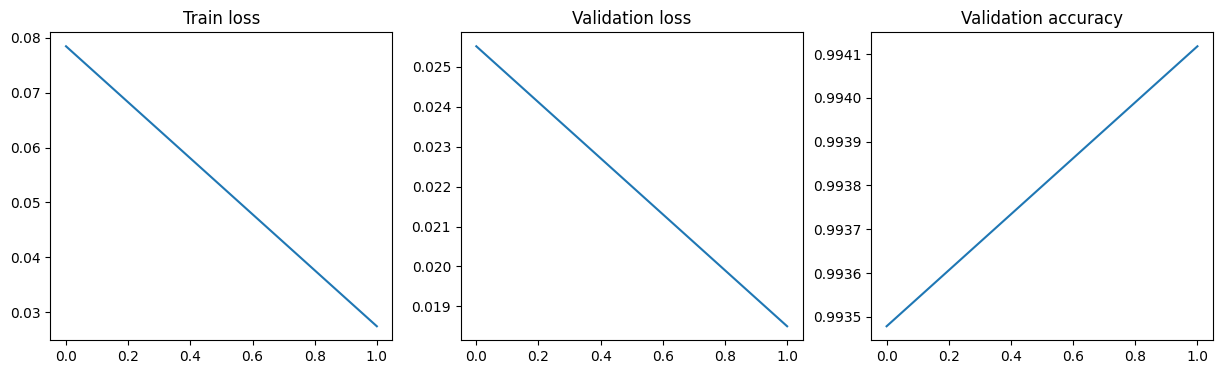

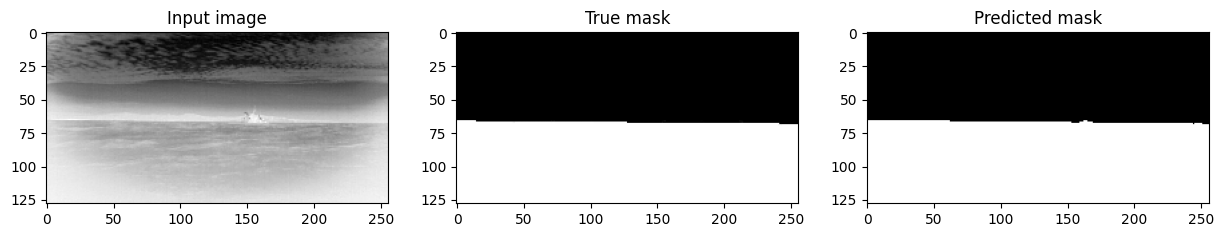

100%|██████████| 1247/1247 [01:38<00:00, 12.65it/s, loss=0.0115]


Tain loss: 0.019792888313531876
=> Saving checkpoint: 
my_checkpoint.pth.tar
Val loss: 0.013031058276053498
Got 116695043/117800960 with acc 99.06
Dice score: 0.9955682027857083


<Figure size 640x480 with 0 Axes>

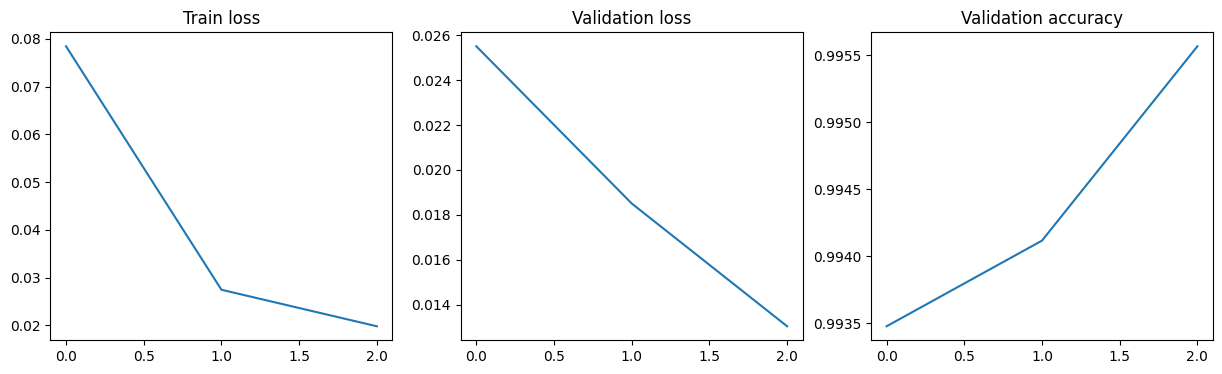

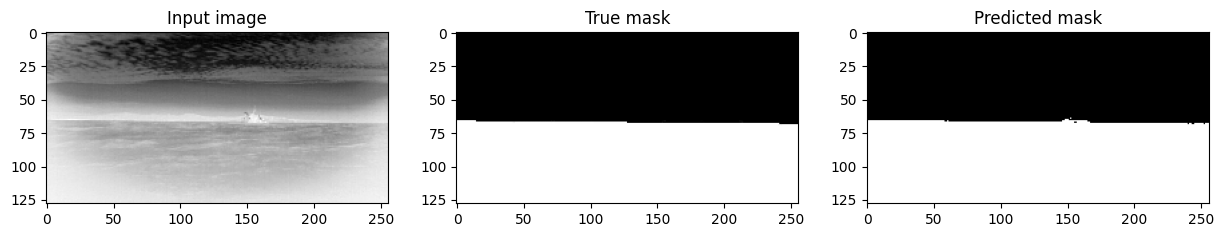

100%|██████████| 1247/1247 [01:39<00:00, 12.55it/s, loss=0.00954]


Tain loss: 0.017869653180241585
=> Saving checkpoint: 
my_checkpoint.pth.tar
Val loss: 0.01276445901073159
Got 116707592/117800960 with acc 99.07
Dice score: 0.9956444322863993


<Figure size 640x480 with 0 Axes>

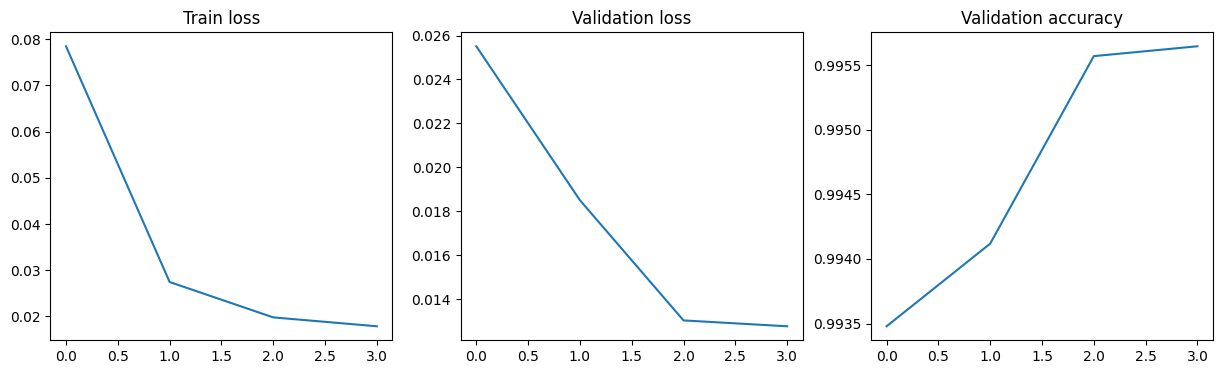

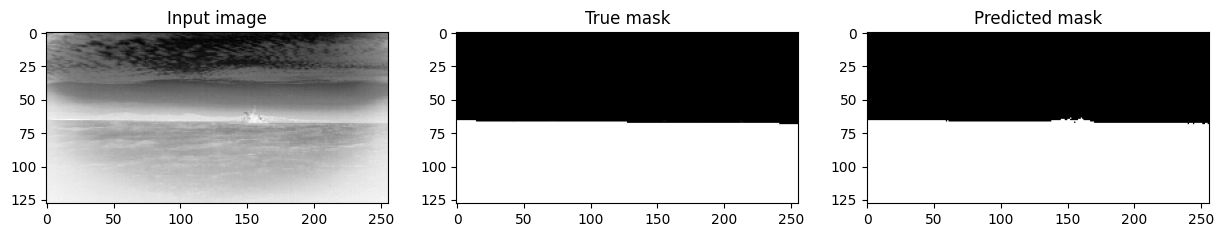

100%|██████████| 1247/1247 [01:40<00:00, 12.41it/s, loss=0.0046]


Tain loss: 0.015004276297986507
=> Saving checkpoint: 
my_checkpoint.pth.tar
Val loss: 0.00898559571728649
Got 116836663/117800960 with acc 99.18
Dice score: 0.9967821177439111


<Figure size 640x480 with 0 Axes>

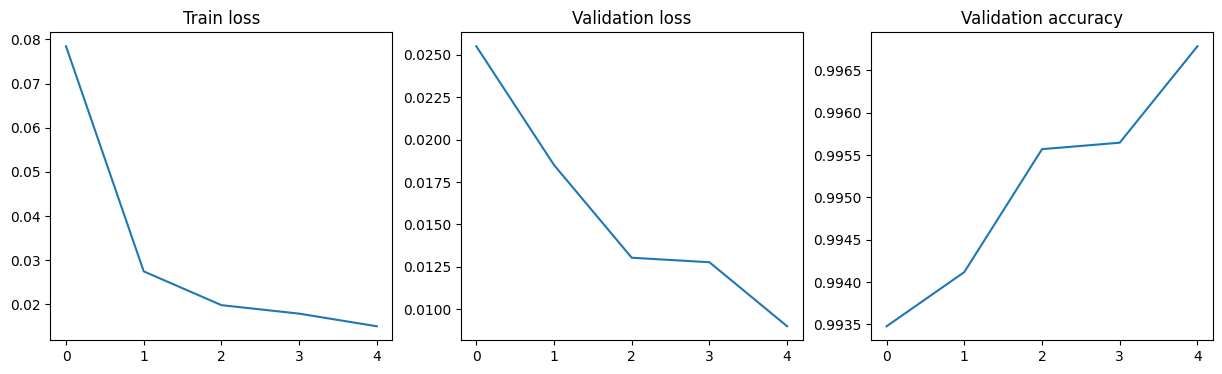

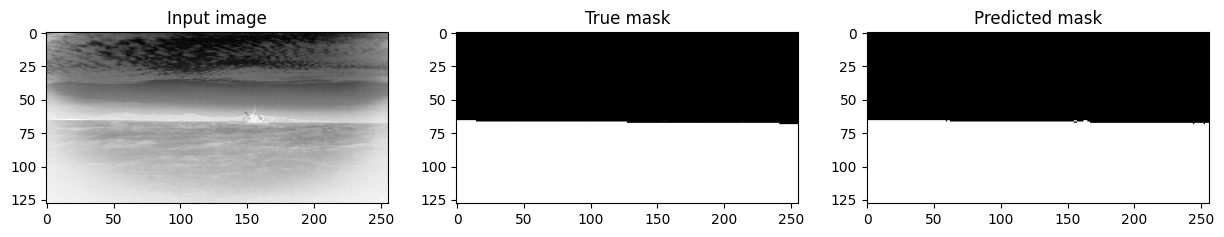

100%|██████████| 1247/1247 [01:43<00:00, 12.02it/s, loss=0.00873]


Tain loss: 0.013337177224457264
=> Saving checkpoint: 
my_checkpoint.pth.tar
Val loss: 0.010319699189864986
Got 116772160/117800960 with acc 99.13
Dice score: 0.9962443670255854


<Figure size 640x480 with 0 Axes>

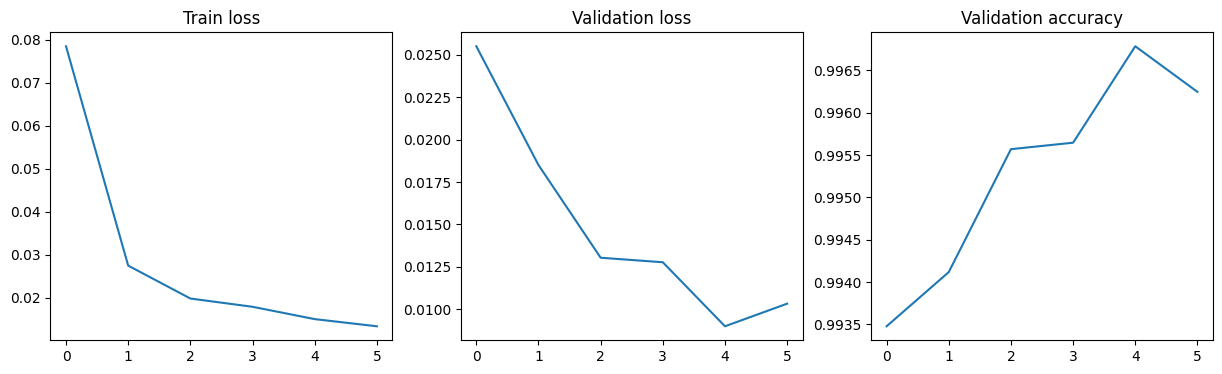

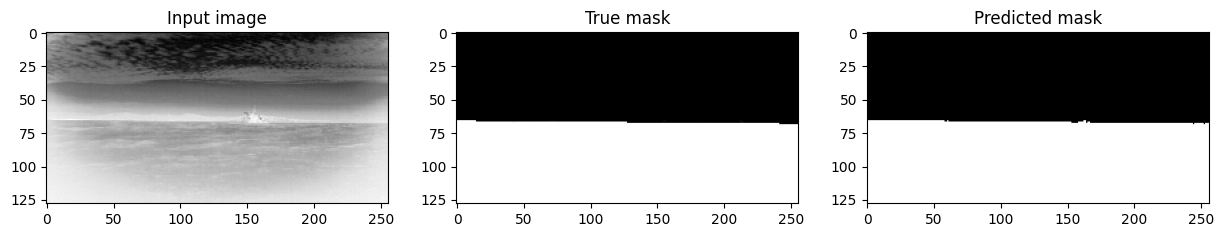

100%|██████████| 1247/1247 [01:42<00:00, 12.13it/s, loss=0.00636]


Tain loss: 0.01310831867158413
=> Saving checkpoint: 
my_checkpoint.pth.tar
Val loss: 0.03383922235091301
Got 115998617/117800960 with acc 98.47
Dice score: 0.9891911949941659


<Figure size 640x480 with 0 Axes>

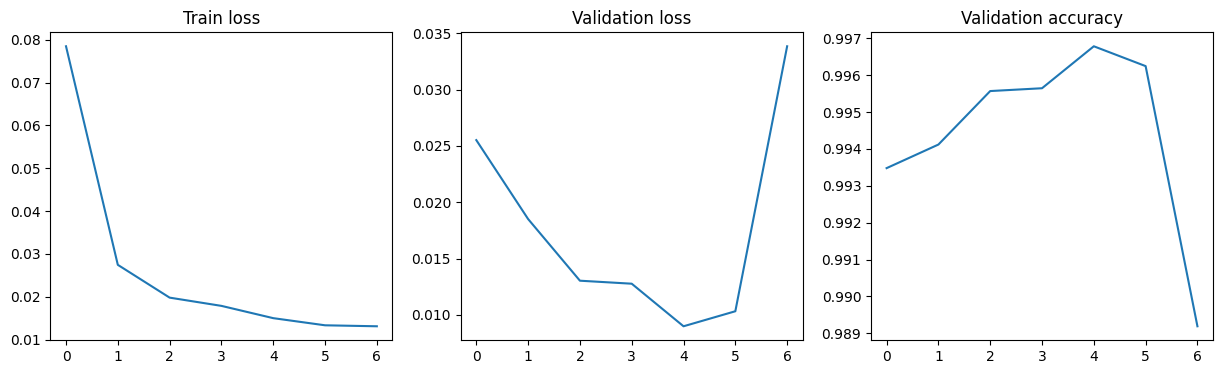

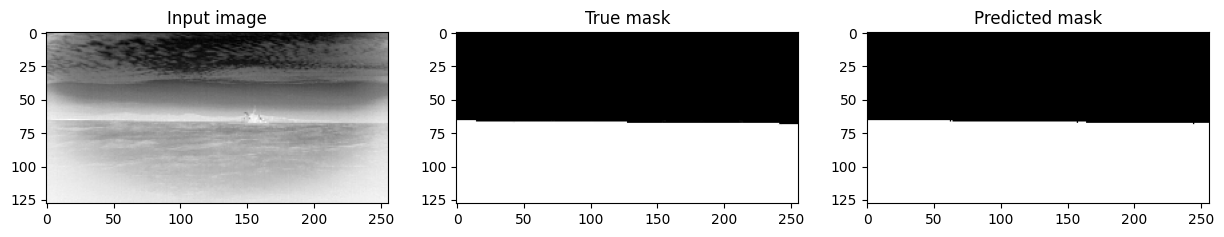

100%|██████████| 1247/1247 [01:45<00:00, 11.87it/s, loss=0.00801]


Tain loss: 0.011675693094730377
=> Saving checkpoint: 
my_checkpoint.pth.tar
Val loss: 0.007790980462914123
Got 116863540/117800960 with acc 99.20
Dice score: 0.9970121519584146


<Figure size 640x480 with 0 Axes>

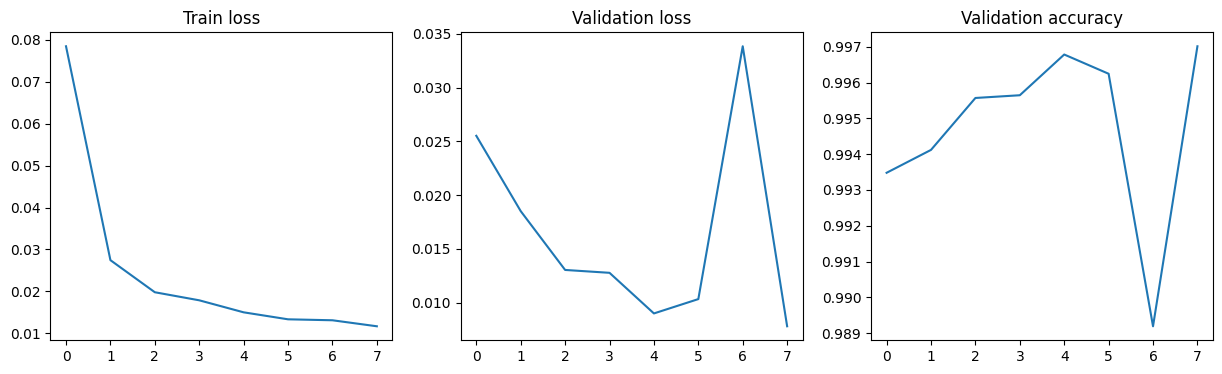

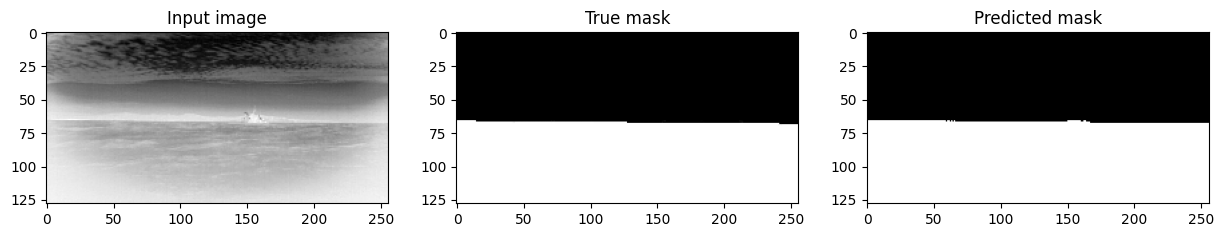

100%|██████████| 1247/1247 [01:45<00:00, 11.84it/s, loss=0.0109]


Tain loss: 0.01164274476468563
=> Saving checkpoint: 
my_checkpoint.pth.tar
Val loss: 0.04945104014793011
Got 115619969/117800960 with acc 98.15
Dice score: 0.9858921831919168


<Figure size 640x480 with 0 Axes>

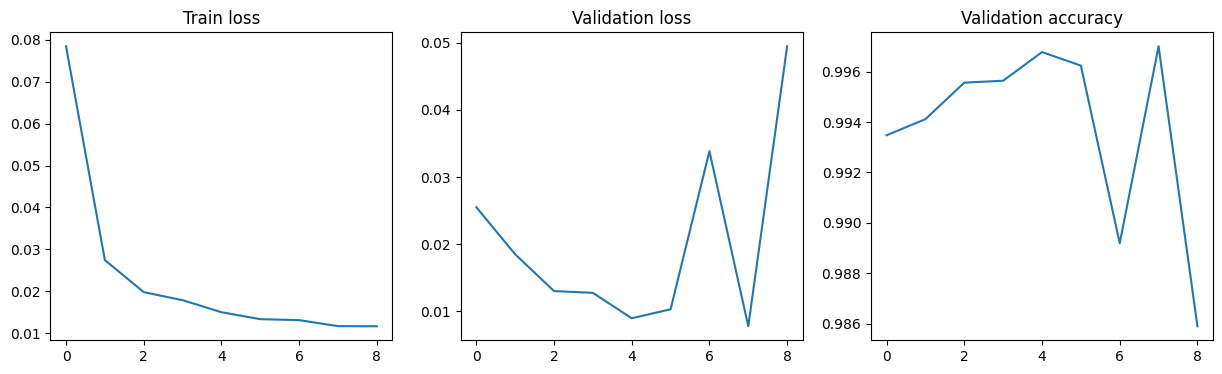

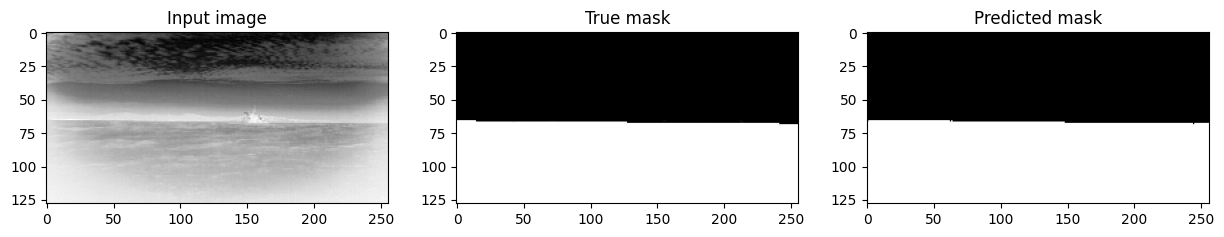

100%|██████████| 1247/1247 [01:46<00:00, 11.76it/s, loss=0.00624]


Tain loss: 0.010297110304236412
=> Saving checkpoint: 
my_checkpoint.pth.tar
Val loss: 0.007847685164728464
Got 116855328/117800960 with acc 99.20
Dice score: 0.9969368327711527


<Figure size 640x480 with 0 Axes>

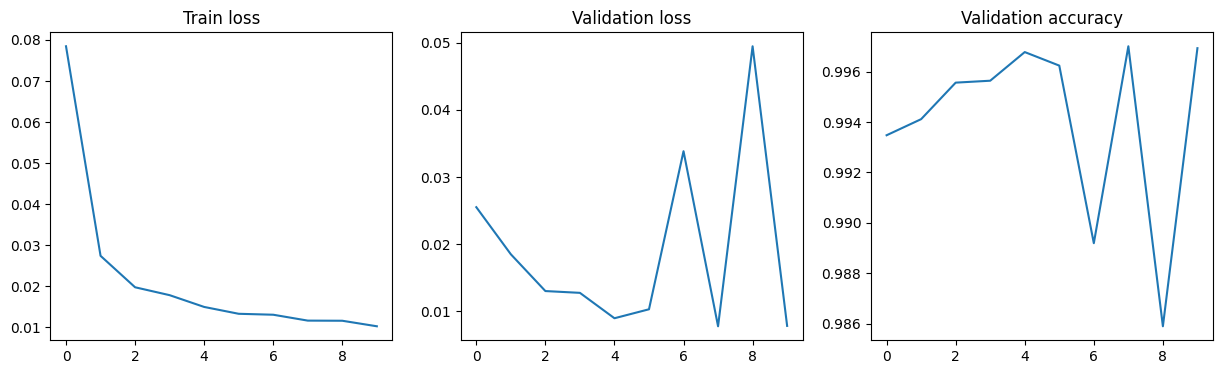

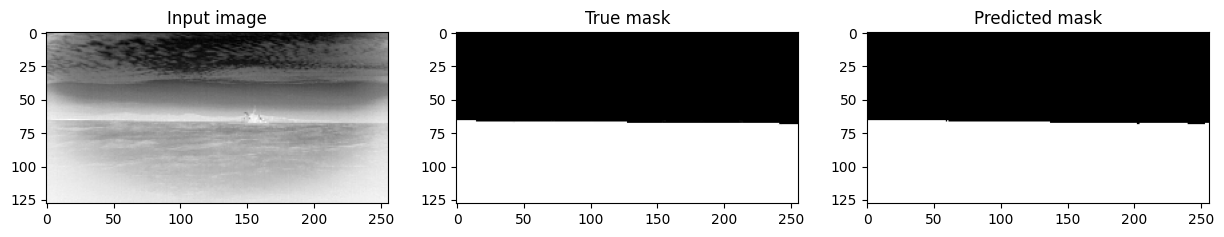

UNET(
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNor

<Figure size 640x480 with 0 Axes>

In [26]:
hyper_parameters = HyperParameters(learning_rate = 1e-4, batch_size = 4, epoch_numbers = 10,device="cuda")
run_training(hyper_parameters)

# Evaluation

<ipython-input-37-38add0d9e8d8>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_checkpoint(torch.load('my_checkpoint.pth.tar'), model)


=> Loading checkpoint
y size : torch.Size([4, 1, 128, 256])
preds size: torch.Size([4, 1, 128, 256])


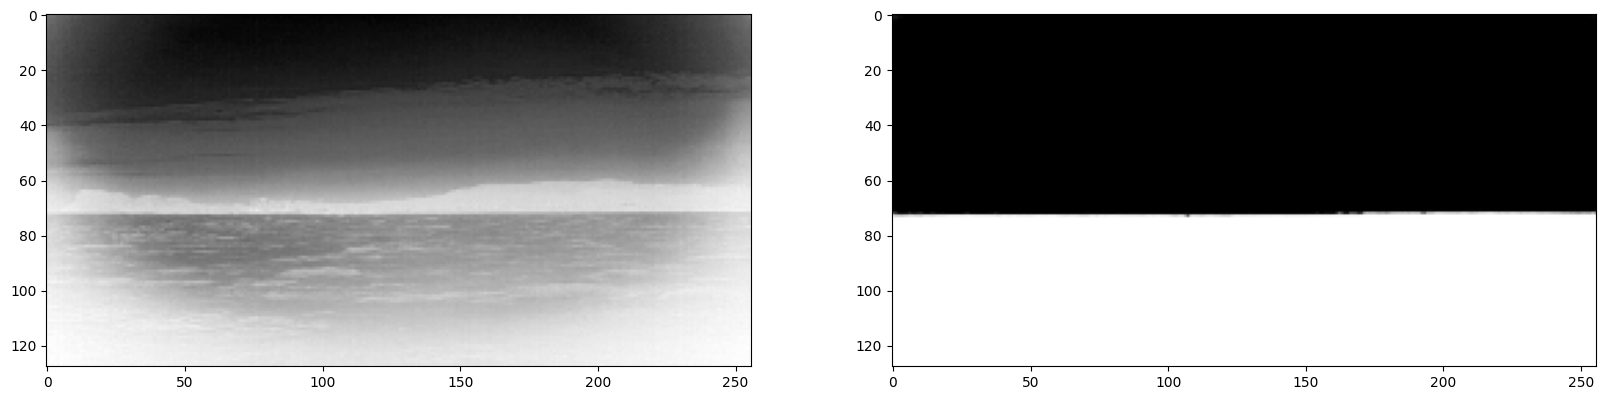

In [37]:
import albumentations as A
model = UNET(in_channels=3, out_channels=1).to(device=DEVICE)
load_checkpoint(torch.load('my_checkpoint.pth.tar'), model) #loading the saved model parameters and weights for the U-NET model

val_transforms = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=[0.0],
                std=[1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

val_ds = HorizonDataset(
        image_dir=VAL_IMG_DIR,
        mask_dir=VAL_MASK_DIR,
        transform=val_transforms
    )

val_loader = DataLoader(
        val_ds,
        batch_size= 4,
        num_workers=2,
        pin_memory=True,
        shuffle=False
)

val_images, val_masks = next(iter(val_loader))

data = val_images.to(device=DEVICE) #move image to the selected CPU or GPU
with torch.no_grad():
    y = model(data) #getting predictions


preds = torch.sigmoid(y) #applying thresholding
print(f"y size : {y.size()}")
print(f"preds size: {preds.size()}")

preds = preds.cpu().numpy() #move predictions to cpu and convert to numpy arrays to plot the output

f = plt.figure(figsize=(20, 5))
f.add_subplot(1,2, 1)
plt.imshow(val_images[1][0], cmap="gray") #input image
f.add_subplot(1,2, 2)
plt.imshow(preds[1][0], cmap="gray") #predicted mask (segmentation map)
plt.show(block=True)

